# Customer Support Chatbot

Here, we show an example of building a customer support chatbot.
This chatbot has two different states: 
1. Music: the user can inquire about different songs and albums present in the store
2. Account: the user can ask questions about their account

Under the hood, this is handled by two separate agents. 
Each has a specific prompt and tools related to their objective. 
There is also a generic agent who is responsible for routing between these two agents as needed.

In [1]:
%pip install -U -q langgraph langchain-openai langchain-community scikit-learn langgraph-checkpoint-sqlite python-dotenv


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.12/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

## Load the data

Utils to pull the Chinook database, populate an in-memory SQLite database, and create the engine.

In [3]:
import sqlite3
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_engine_for_chinook_db():
    """Pull sql file, populate in-memory database, and create engine."""
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    response = requests.get(url)
    sql_script = response.text

    connection = sqlite3.connect(":memory:", check_same_thread=False)
    connection.executescript(sql_script)
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )

engine = get_engine_for_chinook_db()
db = SQLDatabase(engine)

In [4]:
print(db.get_usable_table_names())
print(db)

['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


## Load an LLM

We will load a language model to use.
For this demo we will use OpenAI.

In [5]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")

## Load Other Modules

Load other modules we will use.

All of the tools our agents will use will be custom tools. As such, we will use the `@tool` decorator to create custom tools.

We will pass in messages to the agent, so we load `HumanMessage` and `SystemMessage`

In [6]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage

## Define the Customer Agent

This agent is responsible for looking up customer information.
It will have a specific prompt as well a specific tool to look up information about that customer (after asking for their user id).

In [7]:
# This tool is given to the agent to look up information about a customer
@tool
def get_customer_info(customer_id: int):
    """Look up customer info given their ID. ALWAYS make sure you have the customer ID before invoking this."""
    return db.run(f"SELECT * FROM Customer WHERE CustomerID = {customer_id};")

In [8]:
customer_prompt = """Your job is to help a user update their profile.

You only have certain tools you can use. These tools require specific input. If you don't know the required input, then ask the user for it.

If you are unable to help the user, you can """

def get_customer_messages(messages):
    return [SystemMessage(content=customer_prompt)] + messages

customer_chain = get_customer_messages | model.bind_tools([get_customer_info])

## Define the Music Agent

This agent is responsible for figuring out information about music. To do that, we will create a prompt and various tools for looking up information about music

First, we will create indexes for looking up artists and track names.
This will allow us to look up artists and tracks without having to spell their names exactly right.

First, let's create a tool for getting albums by artist.

In [9]:
@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist."""
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

Next, lets create a tool for getting tracks by an artist

In [10]:
@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

Finally, let's create a tool for looking up songs by their name.

In [11]:
@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

Create the chain to call the relevant tools

In [12]:
song_system_message = """Your job is to help a customer find any songs they are looking for. 

You only have certain tools you can use. If a customer asks you to look something up that you don't know how, politely tell them what you can help with.

When looking up artists and songs, sometimes the artist/song will not be found. In that case, the tools will return information \
on simliar songs and artists. This is intentional, it is not the tool messing up."""
def get_song_messages(messages):
    return [SystemMessage(content=song_system_message)] + messages

LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
song_recc_chain = get_song_messages | model.bind_tools([get_albums_by_artist, get_tracks_by_artist, check_for_songs])

In [13]:
msgs = [HumanMessage(content="hi! can you help me find songs by amy whinehouse?")]
song_recc_chain.invoke(msgs)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Kdz6hSDVN4DeObLAJSl2K1GO', 'function': {'arguments': '{"artist":"Amy Winehouse"}', 'name': 'get_tracks_by_artist'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb3c3cb84d', 'service_tier': 'default'}, id='run--75ee5a55-2e75-4084-813f-ad2d73a196d0-0', tool_calls=[{'name': 'get_tracks_by_artist', 'args': {'artist': 'Amy Winehouse'}, 'id': 'call_Kdz6hSDVN4DeObLAJSl2K1GO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 206, 'output_tokens': 18, 'total_tokens': 224, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Define the Generic Agent

We now define a generic agent that is responsible for handling initial inquiries and routing to the right sub agent.

In [14]:
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field

class Router(BaseModel):
    """Call this if you are able to route the user to the appropriate representative."""
    choice: str = Field(description="should be one of: music, customer")

system_message = """Your job is to help as a customer service representative for a music store.

You should interact politely with customers to try to figure out how you can help. You can help in a few ways:

- Updating user information: if a customer wants to update the information in the user database. Call the router with `customer`
- Recomending music: if a customer wants to find some music or information about music. Call the router with `music`

If the user is asking or wants to ask about updating or accessing their information, send them to that route.
If the user is asking or wants to ask about music, send them to that route.
Otherwise, respond."""
def get_messages(messages):
    return [SystemMessage(content=system_message)] + messages

In [15]:
chain = get_messages | model.bind_tools([Router])

In [16]:
msgs = [HumanMessage(content="hi! can you help me find a good song?")]
chain.invoke(msgs)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_z56Rj6lVBAiO8nUo5aJTesTo', 'function': {'arguments': '{"choice":"music"}', 'name': 'Router'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f64f290af2', 'service_tier': 'default'}, id='run--c8ac673c-ffed-4534-9887-8bf2c0bbf8e5-0', tool_calls=[{'name': 'Router', 'args': {'choice': 'music'}, 'id': 'call_z56Rj6lVBAiO8nUo5aJTesTo', 'type': 'tool_call'}], usage_metadata={'input_tokens': 205, 'output_tokens': 13, 'total_tokens': 218, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
msgs = [HumanMessage(content="hi! whats the email you have for me?")]
chain.invoke(msgs)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_6o3Vm4Zgt9chxLVdOWqbNzyd', 'function': {'arguments': '{"choice":"customer"}', 'name': 'Router'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'service_tier': 'default'}, id='run--a0d11496-8502-4491-834d-f3dfe1de0efe-0', tool_calls=[{'name': 'Router', 'args': {'choice': 'customer'}, 'id': 'call_6o3Vm4Zgt9chxLVdOWqbNzyd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 204, 'output_tokens': 13, 'total_tokens': 217, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [17]:
from langchain_core.messages import AIMessage

def add_name(message, name):
    _dict = message.model_dump()
    _dict["name"] = name
    return AIMessage(**_dict)

In [18]:
from langgraph.graph import END
import json

def _get_last_ai_message(messages):
    for m in messages[::-1]:
        if isinstance(m, AIMessage):
            return m
    return None


def _is_tool_call(msg):
    return hasattr(msg, "additional_kwargs") and 'tool_calls' in msg.additional_kwargs


def _route(messages):
    last_message = messages[-1]
    if isinstance(last_message, AIMessage):
        if not _is_tool_call(last_message):
            return END
        else:
            if last_message.name == "general":
                tool_calls = last_message.additional_kwargs['tool_calls']
                if len(tool_calls) > 1:
                    raise ValueError
                tool_call = tool_calls[0]
                return json.loads(tool_call['function']['arguments'])['choice']
            else:
                return "tools"
    last_m = _get_last_ai_message(messages)
    if last_m is None:
        return "general"
    if last_m.name == "music":
        return "music"
    elif last_m.name == "customer":
        return "customer"
    else:
        return "general"

In [19]:

from langgraph.prebuilt import ToolNode

tools = [get_albums_by_artist, get_tracks_by_artist, check_for_songs, get_customer_info]
tools_node = ToolNode(tools)

In [20]:
def _filter_out_routes(messages):
    ms = []
    for m in messages:
        if _is_tool_call(m):
            if m.name == "general":
                continue
        ms.append(m)
    return ms

In [21]:
from functools import partial

general_node = _filter_out_routes | chain | partial(add_name, name="general")
music_node = _filter_out_routes | song_recc_chain | partial(add_name, name="music")
customer_node = _filter_out_routes | customer_chain | partial(add_name, name="customer")

/var/folders/pw/f8lrbh512sg6058t9_xnvm9r0000gn/T/ipykernel_14041/1551157014.py:5: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  graph = MessageGraph()
/var/folders/pw/f8lrbh512sg6058t9_xnvm9r0000gn/T/ipykernel_14041/1551157014.py:8: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  workflow = MessageGraph()


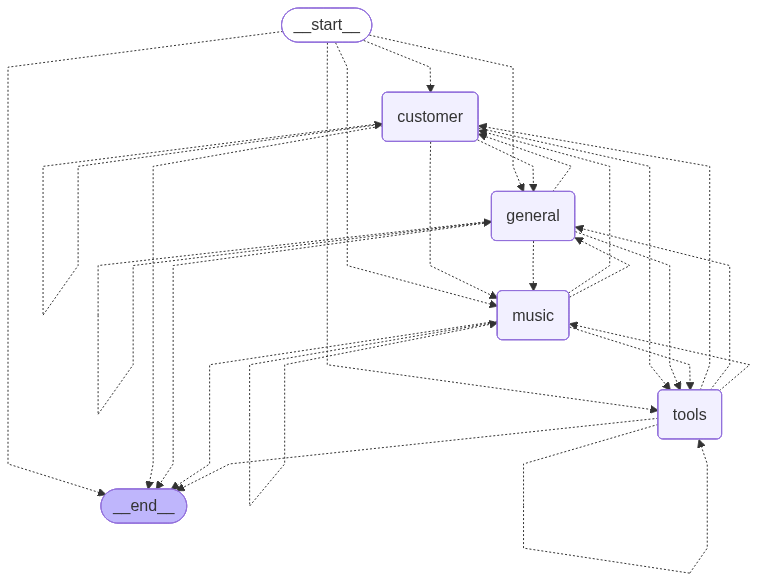

In [30]:
from langgraph.graph import MessageGraph
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")
graph = MessageGraph()
nodes = {"general": "general", "music": "music", END: END, "tools": "tools", "customer": "customer"}
# Define a new graph
workflow = MessageGraph()
workflow.add_node("general", general_node)
workflow.add_node("music", music_node)
workflow.add_node("customer", customer_node)
workflow.add_node("tools", tools_node)
workflow.add_conditional_edges("general", _route, nodes)
workflow.add_conditional_edges("tools", _route, nodes)
workflow.add_conditional_edges("music", _route, nodes)
workflow.add_conditional_edges("customer", _route, nodes)
workflow.set_conditional_entry_point(_route, nodes)
graph = workflow.compile()

from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


## Test it out

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

history = []
while True:
    user = input('User (q/Q to quit): ')
    if user in {'q', 'Q'}:
        break
    history.append(HumanMessage(content=user))
    async for output in graph.astream(history):
        if END in output or START in output:
            continue
        # stream() yields dictionaries with output keyed by node name
        for key, value in output.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    history.append(AIMessage(content=value.content))

User (q/Q to quit):  What do you know about taylor swift? 


Output from node 'general':
---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_PtmNWllKck2m55mmwCfPNn0T', 'function': {'arguments': '{"choice":"music"}', 'name': 'Router'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'service_tier': 'default'} name='general' id='run--fa4d1e16-3ce3-4bc6-b670-2cf190f5dade-0' tool_calls=[{'name': 'Router', 'args': {'choice': 'music'}, 'id': 'call_PtmNWllKck2m55mmwCfPNn0T', 'type': 'tool_call'}] usage_metadata={'input_tokens': 204, 'output_tokens': 13, 'total_tokens': 217, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

---

Output from node 'music':
---
content="I can help you find information about Taylor Swift's albums and songs. If you're interested in her discography or specific tracks, feel free to ask!" additional_kwargs={} response_metadata={'finish_reason': 'stop',

User (q/Q to quit):  Give me information about her albums


Output from node 'general':
---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QqbtvKRAQM0dvNfnKIJbiO3b', 'function': {'arguments': '{"choice":"music"}', 'name': 'Router'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'service_tier': 'default'} name='general' id='run--65d4e1d4-345c-4d92-8699-50bac6d41279-0' tool_calls=[{'name': 'Router', 'args': {'choice': 'music'}, 'id': 'call_QqbtvKRAQM0dvNfnKIJbiO3b', 'type': 'tool_call'}] usage_metadata={'input_tokens': 248, 'output_tokens': 13, 'total_tokens': 261, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

---

Output from node 'music':
---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_fAy10duXNFXdWTNRVUJJOCwj', 'function': {'arguments': '{"artist":"Taylor Swift"}', 'name': 'get_albums_by_artist'}, 'type': 'function'}]} response_metadat

User (q/Q to quit):  show me similar artists


Output from node 'general':
---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_3SFkLBiciKoXHU9CWoKWX1dY', 'function': {'arguments': '{"choice":"music"}', 'name': 'Router'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'service_tier': 'default'} name='general' id='run--9ea4410f-fc82-49b1-8c2b-420f11751703-0' tool_calls=[{'name': 'Router', 'args': {'choice': 'music'}, 'id': 'call_3SFkLBiciKoXHU9CWoKWX1dY', 'type': 'tool_call'}] usage_metadata={'input_tokens': 295, 'output_tokens': 13, 'total_tokens': 308, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

---

Output from node 'music':
---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_gMdT6vZaCCgIdqcz2jxCWNJG', 'function': {'arguments': '{"artist":"Taylor Swift"}', 'name': 'get_tracks_by_artist'}, 'type': 'function'}]} response_metadat

User (q/Q to quit):  q
